epoch: 0, acc: 0.003, loss: 0.496 (data_loss: 0.496, reg_loss: 0.000),lr: 0.005
epoch: 1000, acc: 0.936, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.002501250625312656
epoch: 2000, acc: 0.947, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.0016672224074691564
epoch: 3000, acc: 0.951, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.0012503125781445363
epoch: 4000, acc: 0.954, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.0010002000400080014
epoch: 5000, acc: 0.960, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.0008334722453742291
epoch: 6000, acc: 0.956, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.000714387769681383
epoch: 7000, acc: 0.968, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.0006250781347668457
epoch: 8000, acc: 0.972, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.00055561729081009
epoch: 9000, acc: 0.982, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),lr: 0.0005000500050005
epoch: 10000, acc: 0.981, loss: 0.00

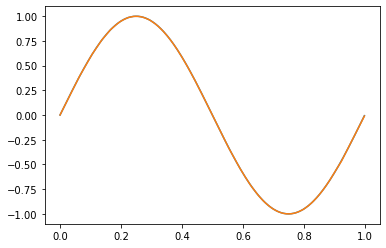

In [3]:
import numpy as np
import nnfs
from nnfs.datasets import sine_data
import matplotlib.pyplot as plt
nnfs.init()

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons,weight_regularizer_l1=0,weight_regularizer_l2=0,
                bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 *dL1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2*self.weight_regularizer_l2 * self.weights
            
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2*self.bias_regularizer_l2*self.biases

        self.dinputs = np.dot(dvalues,self.weights.T)
        
class Layer_Dropout:
    def __init__(self,rate):
        self.rate = 1 - rate
    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1,self.rate, size=inputs.shape)/self.rate
        self.output = inputs * self.binary_mask
    def backward(self,dvalues):
        self.dinputs = dvalues*self.binary_mask

'''activation functions'''
class Activation_ReLU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        
class Activation_Sigmoid:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = 1/(1+np.exp(-inputs))
    def backward(self,dvalues):
        self.dinputs = dvalues*(1-self.output)*self.output
        
class Activation_Softmax:
    def forward(self,inputs):
        self.inputs = inputs
        exp_values=np.exp(inputs-np.max(inputs,axis=1,keepdims=True))
        probabilities = exp_values/np.sum(exp_values,axis=1,keepdims=True)
        self.output = probabilities
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues) #create empty array
        for index, (single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            single_ouput = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_ouput) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)
            
class Activation_Linear:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = inputs
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()

'''optimizers'''          
class Optimizer_SGD:
    def __init__(self,learning_rate=1.,decay=0.,momentum=0.):
        self.learning_rate=learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1/(1+self.decay*self.iterations))
            
    def update_params(self,layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_updates = self.momentum*layer.weight_momentums - self.current_learning_rate*layer.dweights
            layer.weight_momentums = weight_updates
            bias_updates = self.momentum*layer.bias_momentums - self.current_learning_rate*layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate*layer.dweights
            bias_updates = -self.current_learning_rate*layer.dbiases
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    def post_update_params(self):
        self.iterations += 1

        
class Optimizer_Adagrad:
    def __init__(self,learning_rate=1.,decay=0.,epsilon=1e-7):
        self.learning_rate=learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1/(1+self.decay*self.iterations))
            
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2            
        layer.weights += -self.current_learning_rate*layer.dweights/(np.sqrt(layer.weight_cache)+self.epsilon)
        layer.biases += -self.current_learning_rate*layer.dbiases/(np.sqrt(layer.bias_cache)+self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

class Optimizer_RMSprop:
    def __init__(self,learning_rate=0.001,decay=0.,epsilon=1e-7,rho=0.9):
        self.learning_rate=learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1./(1.+self.decay*self.iterations))
            
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache = self.rho*layer.weight_cache + (1-self.rho)*layer.dweights**2
        layer.bias_cache = self.rho*layer.bias_cache + (1-self.rho)*layer.dbiases**2            
        layer.weights += -self.current_learning_rate*layer.dweights/(np.sqrt(layer.weight_cache)+self.epsilon)
        layer.biases += -self.current_learning_rate*layer.dbiases/(np.sqrt(layer.bias_cache)+self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate=learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1/(1+self.decay*self.iterations))
            
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_momentums = self.beta_1*layer.weight_momentums + (1-self.beta_1)*layer.dweights
        layer.bias_momentums = self.beta_1*layer.bias_momentums + (1-self.beta_1)*layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums/(1-self.beta_1**(self.iterations+1))
        bias_momentums_corrected = layer.bias_momentums/(1-self.beta_1**(self.iterations+1))
        
        layer.weight_cache = self.beta_2*layer.weight_cache + (1-self.beta_2)*layer.dweights**2
        layer.bias_cache = self.beta_2*layer.bias_cache + (1-self.beta_2)*layer.dbiases**2     
        weight_cache_corrected = layer.weight_cache/(1-self.beta_2**(self.iterations+1))
        bias_cache_corrected = layer.bias_cache/(1-self.beta_2**(self.iterations+1))
        
        layer.weights += -self.current_learning_rate*weight_momentums_corrected/(np.sqrt(weight_cache_corrected)+self.epsilon)
        layer.biases += -self.current_learning_rate*bias_momentums_corrected/(np.sqrt(bias_cache_corrected)+self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

            
            
'''loss functions'''                      
class Loss:
    def regularization_loss(self,layer):
        regularization_loss = 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights**2)
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases**2)
        return regularization_loss
        
        
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true,axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        #if labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true] #creates matrix with 1s along the diagonal
        self.dinputs = -y_true/dvalues #calculate gradients
        self.dinputs = self.dinputs/samples #normalise    
        
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        self.dinputs = self.dinputs/samples
                       
class Loss_BinaryCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true*np.log(y_pred_clipped)+(1 - y_true)*np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        
        self.dinputs = -(y_true/clipped_dvalues - (1 - y_true)/(1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs/samples
        
class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2*(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
class Loss_MeanAbsoluteError(Loss):
    def forward(self,y_pred,y_true):
        sample_losses= np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples


X,y=sine_data()

dense1 = Layer_Dense(1,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64,1)
activation3 = Activation_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)
#calculate accuracy by checking how many values have a difference from ground truth equivalent smaller than given precision
accuracy_precision = np.std(y) / 250

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    data_loss = loss_function.calculate(activation3.output,y)
    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2)\
    + loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss
    
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions-y) < accuracy_precision)

    if not epoch % 1000:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' + f'reg_loss: {regularization_loss:.3f}),'+
              f'lr: {optimizer.current_learning_rate}')

    loss_function.backward(activation3.output,y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()
    
        
X_test, y_test = sine_data()

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test,y_test)
plt.plot(X_test, activation3.output)
plt.show()